In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('5year.csv',na_values='?')

In [3]:
df=df.rename(columns={'class':'bankrupt'})
# Żmijewski's model consists of 3 independent variables:
# Attr1 = (net profit / total assets)
# Attr2 = (total liabilities / total assets)
# Attr4 = (current assets / short-term liabilities)
dfz=df[['Attr1','Attr2','Attr4','bankrupt']].copy()
dfz=dfz.dropna()

In [4]:
# winsorizing the outliers
from scipy.stats.mstats import winsorize
dfz['Attr1_win']=np.array(winsorize(dfz['Attr1'],limits=[0.05,0.05]))
dfz['Attr2_win']=np.array(winsorize(dfz['Attr2'],limits=[0.05,0.05]))
dfz['Attr4_win']=np.array(winsorize(dfz['Attr4'],limits=[0.05,0.05]))

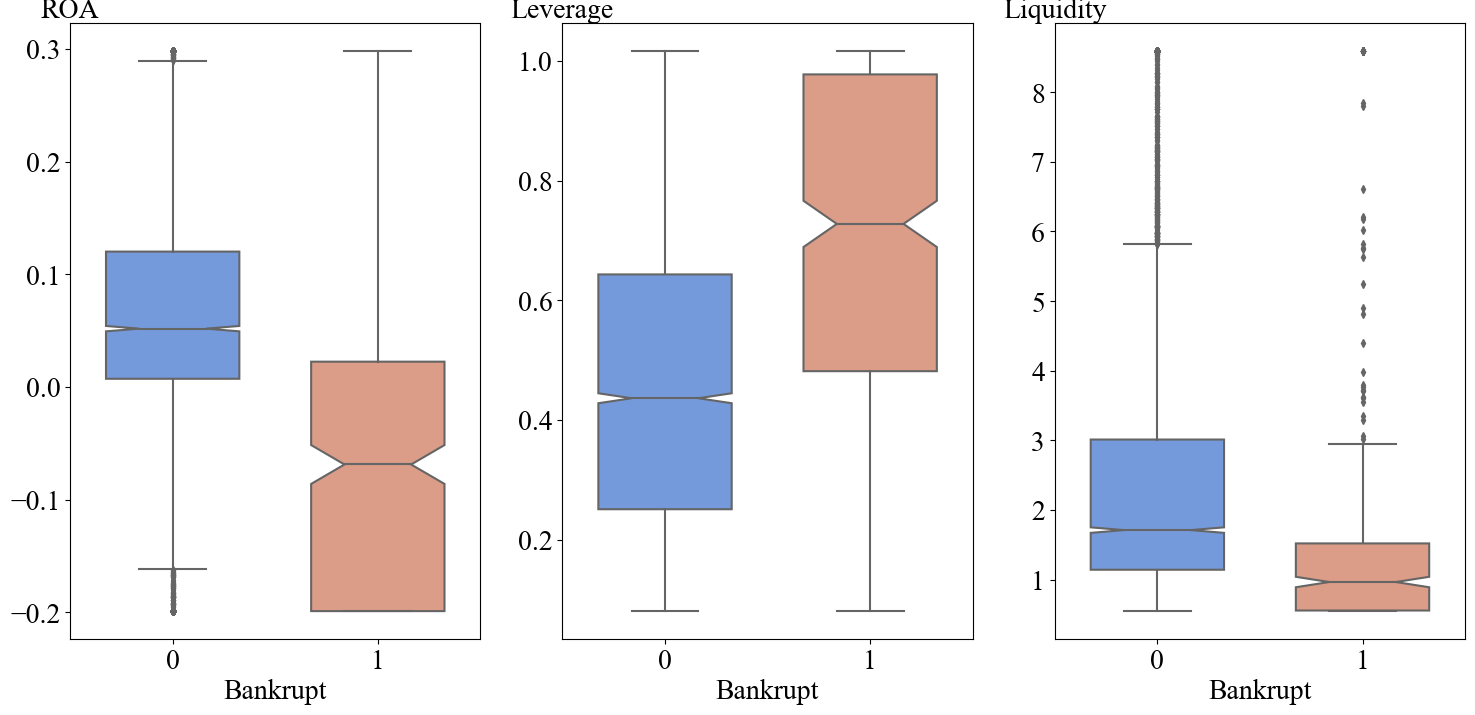

In [5]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelpad']=3
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(18,8))
sns.boxplot(y=dfz['Attr1_win'],x=dfz['bankrupt'],width=0.65,fliersize=4,ax=ax1,notch=True,palette=['cornflowerblue','darksalmon'])
ax1.set_ylabel('ROA',fontdict={'fontsize':20},rotation=0)
sns.boxplot(y=dfz['Attr2_win'],x=dfz['bankrupt'],width=0.65,fliersize=4,ax=ax2,notch=True,palette=['cornflowerblue','darksalmon'])
ax2.set_ylabel('Leverage',fontdict={'fontsize':20},rotation=0)
sns.boxplot(y=dfz['Attr4_win'],x=dfz['bankrupt'],width=0.65,fliersize=4,ax=ax3,notch=True,palette=['cornflowerblue','darksalmon'])
ax3.set_ylabel('Liquidity',fontdict={'fontsize':20},rotation=0)

for i in [ax1,ax2,ax3]:
    i.set_xlabel('Bankrupt',fontdict={'fontsize':20})
    i.yaxis.set_label_coords(0,1)
    for j in ['x','y']:
        i.tick_params(axis=j,labelsize=20)
plt.show()

In [6]:
# adding polynomials
for j in dfz.columns:
    if j != 'bankrupt':
        for i in [2,3]: 
                dfz[j+'_'+str(i)]=np.power(dfz[j],i)

In [7]:
from itertools import combinations
# class for making every possible combination of polynomials
class VariableCombos:
    def __init__(self,include_empty=False):
        self.include_empty=include_empty
    def make_combos(self,variables):
        self.combos=[]
        if not self.include_empty:
            for i in range(1,len(variables)+1):
                for j in combinations(variables,i):
                    self.combos.append(list(j))
        else:
            for i in range(0,len(variables)+1):
                for j in combinations(variables,i):
                    self.combos.append(list(j))
        return self.combos
# function for making every possible pair of two variables (interactions)
def make_pairs(variables):
    pairs=[]
    for i in combinations(variables,2):
        pairs.append(f'{list(i)[0]}*{list(i)[1]}')
    return pairs

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix,jaccard_score,balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import train_test_split
# metrics which should be the best for measuring the performance of the model
# the datasdet is imbalanced - the positives (bankruptcies) are less than 7% of all observations
# f1 = 2TP/(2TP+FP+FN)
# jaccard = TP/(TP+FP+FN)
# youden's j statistic = balanced_accuracy_score(adjusted=True) = TP/(TP+FN) + TN/(TN+FP) - 1

In [9]:
vc=VariableCombos(include_empty=True)
# making a list of every possible variant of the base model + interactions
for i in make_pairs(['Attr1_win','Attr2_win','Attr4_win']):
    dfz[i]=dfz[i.split('*')[0]]*dfz[i.split('*')[1]]
poly_vars_win_z_interactions=vc.make_combos(make_pairs(['Attr1_win','Attr2_win','Attr4_win']))
for i in range(0,len(poly_vars_win_z_interactions)):
    poly_vars_win_z_interactions[i]=['Attr1_win','Attr2_win','Attr4_win']+poly_vars_win_z_interactions[i]
# making a list of every possible variant of base model + polynomials
poly_vars_win_z=vc.make_combos(['Attr1_win_2', 'Attr1_win_3', 'Attr2_win_2', 'Attr2_win_3', 'Attr4_win_2','Attr4_win_3'])
for i in range(0,len(poly_vars_win_z)):
    poly_vars_win_z[i]=['Attr1_win','Attr2_win','Attr4_win']+poly_vars_win_z[i]

In [ ]:
# polynomials: normal logistic regression
X=dfz.drop('bankrupt',axis=1).copy()
y=dfz['bankrupt'].copy()
# creating the results dataframe
dfz_win_results=pd.DataFrame(columns=['variables','best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                                      'best_tpr_count','sum_tpr','best_youden_count','sum_youden'])
dfz_win_results['variables']=poly_vars_win_z
dfz_win_results['variables']=dfz_win_results['variables'].astype(str)
dfz_win_results[['best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                 'best_tpr_count','sum_tpr','best_youden_count','sum_youden']]=0
# best_metric_count = amount of times out of all different train-test splits when a given model had the highest score
# sum_metric = sum of every score
# prediction thresholds: if (probability of being 1) >= threshold: y_pred=1 else: y_pred=0
thresholds=list(np.arange(0.05,1,0.05).round(2))
# testing for 19 differnet prediction thresholds, as the standard 50% isn't the only one that can be used
# creating a list of resulkts dataframes for different thresholds
results_df=[]
for i in thresholds:
    results_df.append(dfz_win_results.copy())
for j in range(0,1000): 
    # 1000 different train-test splits
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=j) 
    best_f1=[[0,-1] for x in range(0,len(thresholds))]
    best_gmean=[[0,-1] for x in range(0,len(thresholds))]
    best_jaccard=[[0,-1] for x in range(0,len(thresholds))] 
    best_tpr=[[0,-1] for x in range(0,len(thresholds))]
    best_youden=[[0,-1] for x in range(0,len(thresholds))]
    for i in poly_vars_win_z:
        mod=LogisticRegression(max_iter=1000,solver='newton-cholesky',penalty=None,n_jobs=-1).fit(X_train[i],y_train)
        # newton-cholesky solver is fast (preferred for n_samples>>n_features), always converges and doesn't require the random_state data shuffling
        for k in range(0,len(thresholds)):
            # calculating the different metrics
            y_pred=(mod.predict_proba(X_test[i])[:,1]>=thresholds[k]).astype(int)
            f1=f1_score(y_test,y_pred)  
            results_df[k].at[poly_vars_win_z.index(i),'sum_f1']+=f1
            gmean=geometric_mean_score(y_test,y_pred)
            results_df[k].at[poly_vars_win_z.index(i),'sum_gmean']+=gmean
            jaccard=jaccard_score(y_test,y_pred)
            results_df[k].at[poly_vars_win_z.index(i),'sum_jaccard']+=jaccard
            conf_m=confusion_matrix(y_test,y_pred)
            tpr=conf_m[1][1]/(conf_m[1][1]+conf_m[1][0])
            results_df[k].at[poly_vars_win_z.index(i),'sum_tpr']+=tpr
            youden=balanced_accuracy_score(y_test,y_pred,adjusted=True)
            results_df[k].at[poly_vars_win_z.index(i),'sum_youden']+=youden
            # the metrics which enter the final scoreboard are chosen like this
            # if a model is having the highest given metric on a given train-test split:
            # best_given_metric_count+=1
            # for every model:
            # given_metric_sum+=given_metric
            for l in [[f1,best_f1],[gmean,best_gmean],[jaccard,best_jaccard],[tpr,best_tpr],[youden,best_youden]]:
                if l[0]>l[1][k][0]:
                    l[1][k][0]=l[0]
                    l[1][k][1]=poly_vars_win_z.index(i)
    for m in [(best_f1,'best_f1_count'),(best_gmean,'best_gmean_count'),(best_jaccard,'best_jaccard_count'),
              (best_tpr,'best_tpr_count'),(best_youden,'best_youden_count')]:
        for n in range(0,len(thresholds)):
            if m[0][n][1]!=-1:
                results_df[n].at[m[0][n][1],m[1]]+=1 
# writing the results      
for i in thresholds:
    results_df[thresholds.index(i)].to_csv(f"/results_z_win/threshold({format(i,'.2f').replace('.',',')}).csv",index=False)

In [ ]:
# polynomials: weighted logistic regression
X=dfz.drop('bankrupt',axis=1).copy()
y=dfz['bankrupt'].copy()
dfz_win_results=pd.DataFrame(columns=['variables','best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                                      'best_tpr_count','sum_tpr','best_youden_count','sum_youden'])
dfz_win_results['variables']=poly_vars_win_z
dfz_win_results['variables']=dfz_win_results['variables'].astype(str)
dfz_win_results[['best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                 'best_tpr_count','sum_tpr','best_youden_count','sum_youden']]=0
results_df=[]
thresholds=list(np.arange(0.05,1,0.05).round(2))
for i in thresholds:
    results_df.append(dfz_win_results.copy())
for j in range(0,1000):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=j)
    best_f1=[[0,-1] for x in range(0,len(thresholds))]
    best_gmean=[[0,-1] for x in range(0,len(thresholds))]
    best_jaccard=[[0,-1] for x in range(0,len(thresholds))]
    best_tpr=[[0,-1] for x in range(0,len(thresholds))]
    best_youden=[[0,-1] for x in range(0,len(thresholds))]
    for i in poly_vars_win_z:
        mod=LogisticRegression(max_iter=1000,solver='newton-cholesky',penalty=None,class_weight='balanced',n_jobs=-1).fit(X_train[i],y_train)
        for k in range(0,len(thresholds)):
            y_pred=(mod.predict_proba(X_test[i])[:,1]>=thresholds[k]).astype(int)
            f1=f1_score(y_test,y_pred)  
            results_df[k].at[poly_vars_win_z.index(i),'sum_f1']+=f1
            gmean=geometric_mean_score(y_test,y_pred)
            results_df[k].at[poly_vars_win_z.index(i),'sum_gmean']+=gmean
            jaccard=jaccard_score(y_test,y_pred)
            results_df[k].at[poly_vars_win_z.index(i),'sum_jaccard']+=jaccard
            conf_m=confusion_matrix(y_test,y_pred)
            tpr=conf_m[1][1]/(conf_m[1][1]+conf_m[1][0])
            results_df[k].at[poly_vars_win_z.index(i),'sum_tpr']+=tpr
            youden=balanced_accuracy_score(y_test,y_pred,adjusted=True)
            results_df[k].at[poly_vars_win_z.index(i),'sum_youden']+=youden
            for l in [[f1,best_f1],[gmean,best_gmean],[jaccard,best_jaccard],[tpr,best_tpr],[youden,best_youden]]:
                if l[0]>l[1][k][0]:
                    l[1][k][0]=l[0]
                    l[1][k][1]=poly_vars_win_z.index(i)
    for m in [(best_f1,'best_f1_count'),(best_gmean,'best_gmean_count'),(best_jaccard,'best_jaccard_count'),
              (best_tpr,'best_tpr_count'),(best_youden,'best_youden_count')]:
        for n in range(0,len(thresholds)):
            if m[0][n][1]!=-1:
                results_df[n].at[m[0][n][1],m[1]]+=1       
for i in thresholds:
    results_df[thresholds.index(i)].to_csv(f"/results_z_win_weighted/threshold({format(i,'.2f').replace('.',',')}).csv",index=False)

In [ ]:
# interactions: normal logistic regression
X=dfz.drop('bankrupt',axis=1).copy()
y=dfz['bankrupt'].copy()
dfz_win_results=pd.DataFrame(columns=['variables','best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                                      'best_tpr_count','sum_tpr','best_youden_count','sum_youden'])
dfz_win_results['variables']=poly_vars_win_z_interactions
dfz_win_results['variables']=dfz_win_results['variables'].astype(str)
dfz_win_results[['best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                 'best_tpr_count','sum_tpr','best_youden_count','sum_youden']]=0
results_df=[]
thresholds=list(np.arange(0.05,1,0.05).round(2))
for i in thresholds:
    results_df.append(dfz_win_results.copy())
for j in range(0,1000):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=j,n_jobs=-1)
    best_f1=[[0,-1] for x in range(0,len(thresholds))]
    best_gmean=[[0,-1] for x in range(0,len(thresholds))]
    best_jaccard=[[0,-1] for x in range(0,len(thresholds))]
    best_tpr=[[0,-1] for x in range(0,len(thresholds))]
    best_youden=[[0,-1] for x in range(0,len(thresholds))]
    for i in poly_vars_win_z_interactions:
        mod=LogisticRegression(max_iter=1000,solver='newton-cholesky',penalty=None).fit(X_train[i],y_train)
        for k in range(0,len(thresholds)):
            y_pred=(mod.predict_proba(X_test[i])[:,1]>=thresholds[k]).astype(int)
            f1=f1_score(y_test,y_pred)  
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_f1']+=f1
            gmean=geometric_mean_score(y_test,y_pred)
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_gmean']+=gmean
            jaccard=jaccard_score(y_test,y_pred)
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_jaccard']+=jaccard
            conf_m=confusion_matrix(y_test,y_pred)
            tpr=conf_m[1][1]/(conf_m[1][1]+conf_m[1][0])
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_tpr']+=tpr
            youden=balanced_accuracy_score(y_test,y_pred,adjusted=True)
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_youden']+=youden
            for l in [[f1,best_f1],[gmean,best_gmean],[jaccard,best_jaccard],[tpr,best_tpr],[youden,best_youden]]:
                if l[0]>l[1][k][0]:
                    l[1][k][0]=l[0]
                    l[1][k][1]=poly_vars_win_z_interactions.index(i)
    for m in [(best_f1,'best_f1_count'),(best_gmean,'best_gmean_count'),(best_jaccard,'best_jaccard_count'),
              (best_tpr,'best_tpr_count'),(best_youden,'best_youden_count')]:
        for n in range(0,len(thresholds)):
            if m[0][n][1]!=-1:
                results_df[n].at[m[0][n][1],m[1]]+=1       
for i in thresholds:
    results_df[thresholds.index(i)].to_csv(f"/results_z_win_interactions/threshold({format(i,'.2f').replace('.',',')}).csv",index=False)

In [ ]:
# interactions: weighted logsistic regression
X=dfz.drop('bankrupt',axis=1).copy()
y=dfz['bankrupt'].copy()
dfz_win_results=pd.DataFrame(columns=['variables','best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                                      'best_tpr_count','sum_tpr','best_youden_count','sum_youden'])
dfz_win_results['variables']=poly_vars_win_z_interactions
dfz_win_results['variables']=dfz_win_results['variables'].astype(str)
dfz_win_results[['best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                 'best_tpr_count','sum_tpr','best_youden_count','sum_youden']]=0
results_df=[]
thresholds=list(np.arange(0.05,1,0.05).round(2))
for i in thresholds:
    results_df.append(dfz_win_results.copy())
for j in range(0,1000):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=j,n_jobs=-1)
    best_f1=[[0,-1] for x in range(0,len(thresholds))]
    best_gmean=[[0,-1] for x in range(0,len(thresholds))]
    best_jaccard=[[0,-1] for x in range(0,len(thresholds))]
    best_tpr=[[0,-1] for x in range(0,len(thresholds))]
    best_youden=[[0,-1] for x in range(0,len(thresholds))]
    for i in poly_vars_win_z_interactions:
        mod=LogisticRegression(max_iter=1000,solver='newton-cholesky',penalty=None,class_weight='balanced').fit(X_train[i],y_train)
        for k in range(0,len(thresholds)):
            y_pred=(mod.predict_proba(X_test[i])[:,1]>=thresholds[k]).astype(int)
            f1=f1_score(y_test,y_pred)  
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_f1']+=f1
            gmean=geometric_mean_score(y_test,y_pred)
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_gmean']+=gmean
            jaccard=jaccard_score(y_test,y_pred)
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_jaccard']+=jaccard
            conf_m=confusion_matrix(y_test,y_pred)
            tpr=conf_m[1][1]/(conf_m[1][1]+conf_m[1][0])
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_tpr']+=tpr
            youden=balanced_accuracy_score(y_test,y_pred,adjusted=True)
            results_df[k].at[poly_vars_win_z_interactions.index(i),'sum_youden']+=youden
            for l in [[f1,best_f1],[gmean,best_gmean],[jaccard,best_jaccard],[tpr,best_tpr],[youden,best_youden]]:
                if l[0]>l[1][k][0]:
                    l[1][k][0]=l[0]
                    l[1][k][1]=poly_vars_win_z_interactions.index(i)
    for m in [(best_f1,'best_f1_count'),(best_gmean,'best_gmean_count'),(best_jaccard,'best_jaccard_count'),
              (best_tpr,'best_tpr_count'),(best_youden,'best_youden_count')]:
        for n in range(0,len(thresholds)):
            if m[0][n][1]!=-1:
                results_df[n].at[m[0][n][1],m[1]]+=1       
for i in thresholds:
    results_df[thresholds.index(i)].to_csv(f"/results_z_win_interactions_weighted/threshold({format(i,'.2f').replace('.',',')}).csv",index=False)

In [ ]:
# balanced random forest classifier on the base model
# creating a random forest model to see how it performs in comparision to the different logistic regressions
X=dfz.drop('bankrupt',axis=1).copy()
y=dfz['bankrupt'].copy()
dfz_win_results=pd.DataFrame(columns=['variables','best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                                      'best_tpr_count','sum_tpr','best_youden_count','sum_youden'])
dfz_win_results['variables']=[['Attr1_win','Attr2_win','Attr4_win']]
dfz_win_results['variables']=dfz_win_results['variables'].astype(str)
dfz_win_results[['best_f1_count','sum_f1','best_gmean_count','sum_gmean','best_jaccard_count','sum_jaccard',
                 'best_tpr_count','sum_tpr','best_youden_count','sum_youden']]=0
results_df=[]
thresholds=list(np.arange(0.05,1,0.05).round(2))
# This^ is the reason why I chose random forest - it can predict_proba
# when it comes to the majority vote, the probability of y being bankrupt can be calculated as follows: 
# (amount of decision trees voting bankrupt)/(total amount of decision trees in the random forest)
for i in thresholds:
    results_df.append(dfz_win_results.copy())
for j in range(0,10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=j)
    best_f1=[[0,-1] for x in range(0,len(thresholds))]
    best_gmean=[[0,-1] for x in range(0,len(thresholds))]
    best_jaccard=[[0,-1] for x in range(0,len(thresholds))]
    best_tpr=[[0,-1] for x in range(0,len(thresholds))]
    best_youden=[[0,-1] for x in range(0,len(thresholds))]
    for i in [['Attr1_win','Attr2_win','Attr4_win']]:
        mod=RandomForestClassifier(n_estimators=1000,max_depth=5,class_weight='balanced',random_state=2812,n_jobs=-1).fit(X_train[i],y_train)
        # min_fraction_leaf=0.2 seems to yield best results. This value was chosen out of arange(0.05,1,0.05)
        for k in range(0,len(thresholds)):
            y_pred=(mod.predict_proba(X_test[i])[:,1]>=thresholds[k]).astype(int)
            f1=f1_score(y_test,y_pred)  
            results_df[k].at[0,'sum_f1']+=f1
            gmean=geometric_mean_score(y_test,y_pred)
            results_df[k].at[0,'sum_gmean']+=gmean
            jaccard=jaccard_score(y_test,y_pred)
            results_df[k].at[0,'sum_jaccard']+=jaccard
            conf_m=confusion_matrix(y_test,y_pred)
            tpr=conf_m[1][1]/(conf_m[1][1]+conf_m[1][0])
            results_df[k].at[0,'sum_tpr']+=tpr
            youden=balanced_accuracy_score(y_test,y_pred,adjusted=True)
            results_df[k].at[0,'sum_youden']+=youden
            for l in [[f1,best_f1],[gmean,best_gmean],[jaccard,best_jaccard],[tpr,best_tpr],[youden,best_youden]]:
                if l[0]>l[1][k][0]:
                    l[1][k][0]=l[0]
                    l[1][k][1]=0
    for m in [(best_f1,'best_f1_count'),(best_gmean,'best_gmean_count'),(best_jaccard,'best_jaccard_count'),
              (best_tpr,'best_tpr_count'),(best_youden,'best_youden_count')]:
       for n in range(0,len(thresholds)):
            if m[0][n][1]!=-1:
                results_df[n].at[m[0][n][1],m[1]]+=1       
for i in thresholds:
    results_df[thresholds.index(i)].to_csv(f"/results_z_win_random_forest/threshold({format(i,'.2f').replace('.',',')}).csv",index=False)